#Collaborative Filtering Recommender Model using surprise library

###download and import

download kaggle and surprise library

In [1]:
! pip install -q kaggle
! pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163335 sha256=03c834567120198b2602190960e541e3573f7901069607d345458a26a8e958f8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


connect google drive for easy use of kaggle API token

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# Your kaggle API token must be provided for correct downloading
! mkdir ~/.kaggle
! chmod 600 /content/gdrive/MyDrive/Colab_Notebooks/kaggle.json
! cp /content/gdrive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
! kaggle datasets download gargmanas/movierecommenderdataset
! mkdir /content/dataset
! unzip movierecommenderdataset.zip -d dataset

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 118MB/s]
Archive:  movierecommenderdataset.zip
  inflating: dataset/movies.csv      
  inflating: dataset/ratings.csv     


importing required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import plotly.express as px

##Dataset analysis

In [5]:
dataset = pd.read_csv("/content/dataset/ratings.csv")
movies = pd.read_csv("/content/dataset/movies.csv")

Dataset rating Info
* userId : unique id for each user who made an evaluation
* movieId : unique id of the movie that was rated by the user
* rating : rating for the corresponding movie by the corresponding user
* timestamp : time of the rating

In [6]:
dataset.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
print('The total number of rows :', dataset.shape[0])
print('The total number of columns :', dataset.shape[1])

The total number of rows : 100836
The total number of columns : 4


Dataset with movies info
* movieId :  unique id of the movie
* title : movie title with release date
* genres : list of genres for corresponding movie

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
print('The total number of rows :', movies.shape[0])
print('The total number of columns :', movies.shape[1])

The total number of rows : 9742
The total number of columns : 3


---

drop timstamp because we won't check the viewing time


In [10]:
dataset.drop('timestamp', axis=1, inplace=True)
dataset.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


check the number of unique data to see how many unique values we are working with

rating has 10 unique so let`s check what these values are

In [11]:
dataset.nunique()

userId      610
movieId    9724
rating       10
dtype: int64

rating values are considered in halves, which will increase the accuracy of the model

In [12]:
np.sort(dataset.rating.unique())

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

check that we don't have any Nan values

In [13]:
dataset.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

---
distribution of values allows us to see if we have an offset for some value

In [14]:
dataset.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [15]:
px.histogram(dataset, x='rating')

the distribution of values is normal, as most of our values go on the mean values 3 and 4, but we don't have enough negative values, which can then overestimate the values for the model

some information:
* values .5, 1 and 1.5 have less than 5k values, which says we have few negative values
* values 2, 2.5, 4.5 have more than 5k values
* 4 has the most values (more than 25k)
* values 3, 3.5 and 5 have values between 10k and 20k.
---

let's look at the number of ratings each user makes, maybe there will be outliers

In [16]:
user_groupby_rating = dataset.groupby('userId')['rating']
user_groupby_rating.count().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

mean of users rating is 165 and min is 20, so we have enough ratings from every user

In [17]:
px.scatter(user_groupby_rating.count())

a few users made a lot of marks, let's see if they spoil our distribution

In [18]:
dataset.loc[dataset.userId.isin([414, 474, 599, 448])].rating.describe()

count    9148.000000
mean        3.079471
std         0.962777
min         0.500000
25%         2.500000
50%         3.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

In [19]:
px.box(dataset.loc[dataset.userId.isin([414, 474, 599, 448])].rating)

In [20]:
px.box(dataset.loc[dataset.userId == 414].rating)

their q1 = 2.5 and q3 = 4

they don't under-rate or praise them, so we can keep them, but let's look at user 414 who gave the most ratings, which films he\she doesn't like:)

In [21]:
movie_unluck_for_414 = dataset.loc[(dataset.userId == 414) & (dataset.rating == 0.5)].movieId
movies.loc[movies.movieId == np.array(movie_unluck_for_414)[0]]

,movieId,title,genres
5270,8666,Catwoman (2004),Action|Crime|Fantasy


In [22]:
movie_luck_for_414 = dataset.loc[(dataset.userId == 414) & (dataset.rating == 5)].movieId
movies.loc[movies.movieId.isin(np.array(movie_luck_for_414).tolist())]

,movieId,title,genres
10,11,"American President, The (1995)",Comedy|Drama|Romance
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
32,34,Babe (1995),Children|Drama
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
83,94,Beautiful Girls (1996),Comedy|Drama|Romance
...,...,...,...
9466,168326,The Big Sick (2017),Comedy|Romance
9497,170705,Band of Brothers (2001),Action|Drama|War
9521,171763,Baby Driver (2017),Action|Crime|Thriller
9571,174055,Dunkirk (2017),Action|Drama|Thriller|War


apparently he's not a comics fan

---

check the number of ratings for the films

In [23]:
movie_groupby_rating = dataset.groupby("movieId")['rating']
movie_groupby_rating.count().describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

In [24]:
px.histogram(movie_groupby_rating.count())

In [25]:
movieid_with_top_count_of_ratings = movies.loc[movies.movieId == 356]
movieid_with_top_count_of_ratings

,movieId,title,genres
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


Text(0, 0.5, 'Movie rating count')

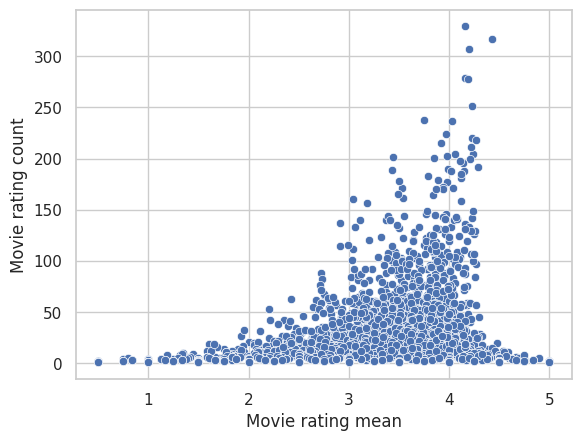

In [26]:
plot = sns.scatterplot(x=movie_groupby_rating.mean(), y=movie_groupby_rating.count())
plot.set_xlabel("Movie rating mean")
plot.set_ylabel("Movie rating count")


In [27]:
px.scatter(x=movie_groupby_rating.mean(), y=movie_groupby_rating.count())

This is a joint plot between Mean rating distribution and Rating Count grouped by all the movies. As shown in the plot, data is clustered between mean rating of 3 to 4.5.

###Observations
we had no outliers, the distribution of estimates suggests a slight lack of negative values, which should not affect the performance of simple models very much. We can proceed to training.

# Fit

import surprise library for training simple models for сollaborative filtering

In [28]:
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate

surprise library have their own train_test split, so we need to convert our dataset to surprise_dataset

In [29]:
reader = Reader()
surprise_data = Dataset.load_from_df(dataset, reader)

for fit lets split .7 for train and .3 for valid

In [30]:
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

we want to get the top recommendations for each user, so we will write a function that will create the top_n predicted ones

In [31]:
from collections import defaultdict

def get_top_n(predictions, n=5):
  top_n = defaultdict(list)
  # for every user we append pred with item id
  for uid, iid, _, est, _ in predictions:
    top_n[uid].append((iid, est))

  # sort values for top
  for iid, rating in top_n.items():
    rating.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = rating[:n]

  return top_n

In [32]:
class collab_filtering_model():
  def __init__(self, model, testset, trainset, data):
    self.model = model
    self.testset = testset
    self.trainset = trainset
    self.data = data
    self.pred_test = None
    self.top_n = None
    self.recommenddf = None

  def fit_and_predict(self):

    # fit the model on train data
    self.model.fit(trainset)
    # get preds and check a rmse value
    self.pred_test = self.model.test(testset)
    rmse = accuracy.rmse(self.pred_test)
    # get top of preds
    self.top_n = get_top_n(self.pred_test)

    print(f"RMSE for model {self.model} is {rmse}")

    self.recommenddf = pd.DataFrame(columns=['uid', 'iid', 'rating'])

    for item in self.top_n:
        subdf = pd.DataFrame(self.top_n[item], columns=['iid', 'rating'])
        subdf['uid'] = item
        cols = subdf.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        subdf = subdf[cols]
        self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)

    return rmse

  def cross_validate(self):
    cv_result = cross_validate(self.model, self.data, n_jobs=-1)
    return cv_result

  def recommend(self, uid, n = 5):
    rec = self.recommenddf.loc[self.recommenddf['uid'] == uid].head(n)
    display(rec)
    return rec

we will use GridSearch to find the best params

lets try to find for KNNBasic model

In [33]:
def find_best_model(model, params, data):
  gs = GridSearchCV(model, params, measures=["rmse"], cv = 3, n_jobs=-1)
  gs.fit(data)
  print(gs.best_score)
  print(gs.best_params)
  print(gs.best_estimator)
  return gs

In [34]:
sim_options = {
    "name": ["cosine", "pearson_baseline"],
    "user_based": [True],
}
params = {"k" : range(40, 60, 1), "sim_options" : sim_options}
bm = find_best_model(KNNBasic, params, surprise_data)

{'rmse': 0.9790652052535868}
{'rmse': {'k': 45, 'sim_options': {'name': 'cosine', 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f79b638e380>}


In [35]:
knn_basic = bm.best_estimator['rmse']
collab_model_knn_basic = collab_filtering_model(knn_basic, testset, trainset, surprise_data)
collab_model_knn_basic.fit_and_predict()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9738
RMSE for model <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f79b638e380> is 0.973788763478025


0.973788763478025

In [36]:
collab_model_knn_basic.cross_validate()

{'test_rmse': array([0.96924082, 0.97142674, 0.97300118, 0.97279471, 0.97779463]),
 'test_mae': array([0.74416577, 0.74738693, 0.74971276, 0.75167778, 0.75346328]),
 'fit_time': (0.21634316444396973,
  0.31621336936950684,
  0.36437249183654785,
  0.32004284858703613,
  0.10868310928344727),
 'test_time': (2.4655847549438477,
  2.166002035140991,
  2.1253771781921387,
  2.055633544921875,
  1.047231674194336)}

In [37]:
collab_model_knn_basic.recommend(1);

,uid,iid,rating
0,1,1210,4.400232
1,1,2571,4.365362
2,1,1927,4.332666
3,1,3147,4.278090
4,1,2329,4.266224


In [38]:
dataset.loc[(dataset['userId'] == 1) & (dataset['movieId'].isin([1210, 1927, 2571, 3147, 2329]))]

,userId,movieId,rating
73,1,1210,5.0
114,1,1927,5.0
147,1,2329,5.0
166,1,2571,5.0
203,1,3147,5.0


our model find the best item id for this user and this user really likes it

##For other surprise algos

In [39]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise import KNNBasic

algos = pd.DataFrame()

for algo in [KNNWithMeans(), SVD(), NMF(), KNNBaseline(), KNNWithZScore(), BaselineOnly(), CoClustering(), KNNBasic()]:
  result = cross_validate(algo, surprise_data, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
  tmp = pd.DataFrame.from_dict(result).mean(axis=0).to_frame().T
  algo_name = pd.DataFrame([str(algo).split(' ')[0].split('.')[-1]], columns=["Algorithm"])
  name_with_value = pd.concat([algo_name, tmp],  axis=1)
  algos = pd.concat([algos, name_with_value], axis=0, ignore_index=True)

algos.set_index('Algorithm').sort_values('test_rmse')

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.872893,0.672954,0.291414,0.263513
SVD,0.874076,0.671424,1.733563,0.202124
KNNBaseline,0.875400,0.669234,0.463284,3.130639
KNNWithMeans,0.896769,0.684827,0.295675,2.865447
KNNWithZScore,0.896826,0.680470,0.300428,2.452982
NMF,0.920617,0.704855,4.015027,0.170982
CoClustering,0.942197,0.730207,2.380173,0.159826
KNNBasic,0.946928,0.725706,0.229277,2.665248


###Observations

Looking at the above result, we can say BaselineOnly model works well with the data as it is having the least RMSE score of 0.872

##Conclusion
The surprise library has excellent functionality for building simple recommender systems with easy-to-use features.